# 2.4 カウントベースの手法の改善

## 2.4.1 相互情報量

前節の共起行列の要素は、2 つの単語が共起した回数を表しています。しかし、こ
の“生” の回数というのはあまり良い性質を持ちません。その理由は、高頻度単語（多
く出現する単語）に目を向けるとはっきりします。
たとえば、あるコーパスにおいて「the」と「car」の共起を考えてみましょう。そ
の場合、「... the car ...」というフレーズは多く見られるでしょう。そのため、その
共起する回数は大きな値になります。一方、「car」と「drive」という単語には明ら
かに強い関連性があります。しかし、単に出現回数だけを見てしまうと、「car」は「drive」よりも「the」のほうに強い関連性を持ってしまうでしょう。つまりこれは、
「the」という単語が高頻度な単語であるがゆえに、「car」と強い関連性を持つように
評価されてしまうということです。
そのような問題を解決するために、相互情報量（Pointwise Mutual Information）
[19] と呼ばれる指標が使われます（以降、PMI と略記）。これはx とy という確率変
数に対して次の式で定義されます（確率については「3.5.1 CBOWモデルと確率」で
詳しく説明します）。

$$
PMI(x, y) = log_2\frac{P(x,y)}{P(x)P(y)}
$$

式(2.2) がPMI の定義式です。ここでP(x) はx が起こる確率、P(y) はy が起
こる確率を表します。そして、P(x, y) はx とy が同時に起こる確率を表します。こ
のPMI は、その値が高いほど関連性が高いことを示します。
これを私たちの自然言語の例に当てはめると、P(x) というのはx という単語がコー
パスに現れる確率を指します。たとえば、10,000 個の単語からなるコーパスで「the」
という単語が100 回出現したとしましょう。そうすると、$ P("the") = \frac{100}{10000} = 0.01 $
となります。また、P(x, y) は単語x とy が共起する確率を表します。これも例を出
すと、たとえば「the」と「car」が10 回共起した場合、$ P("the", "car") = \frac{10}{10000} = 0.001 $
となります。
それでは共起行列（各要素は共起した単語の回数）を使って、式(2.2) を書き換え
てみましょう。ここでは共起行列をC として、単語x とy の共起する回数をC(x, y)
で表します。また、単語x、y の出現する回数はそれぞれC(x)、C(y) で表します。
このとき、コーパスに含まれる単語数をN とすると、式(2.2) は次のように書き換
えられます。

$$
PMI(x, y) = log_2\frac{P(x,y)}{P(x)P(y)} = log_2\frac{\frac{C(x,y)}{N}}{\frac{C(x)}{N}\frac{C(y)}{N}} =log_2\frac{C(x,y)*N}{C(x)C(y)}
$$

式(2.3) によって、共起行列からPMI を求めることができます。それでは式(2.3)
を使って、具体的に計算してみましょう。ここでは、コーパス中の単語数（N）を
10,000 として、「the」が1,000 回、「car」が20 回、「drive」が10 回出現したとし
ます。そして、「the」と「car」の共起が10 回、「car」と「drive」の共起が5 回だ
と仮定しましょう。このとき、共起する回数の視点では、「car」は、「drive」よりも
「the」のほうに関連性が強いことになります。では、PMI の視点ではどうでしょうか。これは次のように計算できます。

$$
PMI("the", "car") = log_2\frac{10*10000}{1000*20} ≒ 2.32
$$
$$
PMI("car", "drive") = log_2\frac{5*10000}{20*10} ≒ 7.97
$$

この結果が示すとおり、PMI を用いることで、「car」は、「the」よりも「drive」の
ほうに関連性を持つようになりました。これは私たちの要望どおりの結果です。この
ような結果になったのは、単語単独の出現回数が考慮されたことによります。この例
では、「the」が多く出現していることから、PMI のスコアが低減されたのです。な
お、式中の≈ は「ニアリー・イコール」という記号で、近似的に等しいことを意味し
ます。
これでPMI という良い指標を手にできましたが、このPMI にはひとつ問題があ
ります。それは2 つの単語で共起する回数が0 の場合、log2 0 = −∞ となってしま
う点です。それに対応するため、実践上では次の正の相互情報量（Positive PMI）が
使われます（以降、PPMI と略記）。

$$
PPMI(x, y) = max(0, PMI(x, y))
$$

式(2.6) により、PMI がマイナスのときは、それを0 として扱います。これ
で、単語間の関連度を0 以上の実数によって表すことができます。それでは、共
起行列をPPMI 行列に変換する関数を実装しましょう。私たちはそれをppmi(C,
verbose=False, eps=1e-8) という名前で実装します（ common/util.py）

```python
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI（正の相互情報量）の作成

    :param C: 共起行列
    :param verbose: 進行状況を出力するかどうか
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M
```

ここで引数のC は共起行列、verbose は進行状況を出力するかどうかを決めるフ
ラグを表します。このverbose は大きなコーパスを扱う際に、verbose=True とす
ることで、進行状況を確認する用途に利用します。このコードでは、共起行列だけからPPMI 行列を求められるようにするために簡易的な実装を行っています。具体的には、単語x とy の共起する回数をC(x, y) としたとき、
$ C(x)=\sum_{i}C(i,x)$、
$ C(y)=\sum_{i}C(i,y)$、
$ N=\sum_{i}\sum_{j}C(i,j)$
であるものとして――そのような近似を
行い――実装しています。また、上のコードではnp.log2(0)=-inf を避けるため
にeps という微小な値を使用しています。

それでは、共起行列をPPMI 行列に変換してみましょう。これは次のように実装
できます（ ch02/ppmi.py）。

In [1]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 有効桁３桁で表示
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)


covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


これで、共起行列をPPMI 行列に変換することができました。このとき、PPMI
行列の各要素は0 以上の実数値です。これで私たちはより良い指標からなる行列――
より良い単語ベクトル――を手にできたのです。
しかし、このPPMI 行列にも、まだ大きな問題があります。それは、コーパスの
語彙数が増えるにつれて、各単語のベクトルの次元数も増えていくという問題です。
たとえば、コーパスに含まれる語彙数が10 万に達すれば、そのベクトルの次元数も
同様に10 万になります。実際のところ、10 万次元のベクトルを扱うというのはあま
り現実的ではありません。
また、この行列の中身を見てみると、その要素の多くが0 であることが分かりま
す。これは、ベクトルのほとんどの要素が重要ではない――つまり、各要素の持つ
“重要度” は低いということを意味します。そして、そのようなベクトルは、ノイズに
弱く、頑健性に乏しいという欠点があります。こういった問題に対してよく行われる
のが、ベクトルの次元削減です。

## 2.4.2 次元削減

次元削減（dimensionality reduction）は、文字どおり、ベクトルの次元を削減す
る手法を指します。ただし、単に削減するのではなく、“重要な情報” をできるだけ残
した上で削減するというところがポイントです。直感的なイメージとしては、図2-8
に示すように、データの分布を見て重要な“軸” を見つけることを行います。

![2_8](fig/2_8.png)

図2-8 では、元々は2 次元の座標で表されていたデータ点を、データの広がりを考慮して、ひとつの座標軸で表すように新たな軸を導入します。このとき各データ点の値は、新しい軸への射影された値によって表されます。ここで大切な点は、データの広がりを考慮した軸をとることで、1 次元の値だけでもデータの本質的な差異を捉えられるということです。これと同じようなことは、さらに多次元のデータでも行えます。

次元削減を行う方法はいくつかあります。ここでは特異値分解（Singular Value
Decomposition：SVD）を使った次元削減を行います。SVD は、任意の行列を3 つ
の行列の積へと分解します。数式で書くと、次のように表されます。

$$ X = USV^T $$

式(2.7) が示すように、SVD は、任意の行列X を、U、S、V の3 つの行列の積
に分解します。ここでU とV は直交行列であり、その列ベクトルは互いに直交しま
す。また、S は対角行列であり、これは対角成分以外はすべて0 の行列です。このとき、これらの行列を視覚的に表すと、図2-9 のようになります。

![2_9](fig/2_9.png)


さて、式(2.7) においてU は直交行列です。そして、この直交行列は何らかの空
間の軸（基底）を形成しています。私たちの文脈においては、このU という行列を
「単語空間」として扱うことができるのです。また、S は対角行列で、この対角成分
には、「特異値」というものが大きい順に並んでいます。特異値とは、簡単に言えば、
「対応する軸」の重要度とみなすことができます。そこで、図2-10 のように、重要で
ない要素を削ることが考えられます。

![2_10](fig/2_10.png)

図2-10 に示すように、行列S の特異値が小さいものは重要度が低いので、行列U
から余分な列ベクトルを削ることで、元の行列を近似することができます。これを私
たちが扱っている「単語のPPMI 行列」に当てはめると、行列X の各行には対応す
る単語ID の単語ベクトルが格納されており、それらの単語ベクトルが行列U′ とし
て次元削減されたベクトルで表現されることになります。

## 2.4.3 SVDによる次元削減

Python で実際にSVD を行ってみましょう。このSVD はNumPy のlinalg モ
ジュールにあるsvd というメソッドで実行できます。ちなみに、linalg とはlinear
algebra（線形代数）の略称です。それでは、共起行列を作り、PPMI 行列に変換し、
それに対してSVD を適用します（ ch02/count_method_small.py）

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


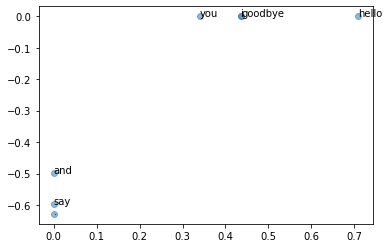

In [2]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 有効桁３桁で表示
print(C[0])
print(W[0])
print(U[0])

# plot
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()


このプロット図を見ると、「goodbye」と「hello」、「you」と「i」が近い場所に位
置することが分かります。これは私たちの直感と比較的近いものでしょう。しかし、
ここでは小さなコーパスを使っている関係で、この結果は正直微妙なものです。それ
では続いてPTB データセットという、より大きなコーパスを使って同じ実験を行っ
てみます。まずはPTB データセットについて簡単に説明します。

## 2.4.4 PTBデータセット

これまで私たちは、とても小さなテキストデータをコーパスとして使用してきまし
た。ここでは、“本格的” なコーパス――それでいて大きすぎない手ごろなコーパス
――を利用したいと思います。それはPenn Treebank（ペン・ツリー・バンク）と呼
ばれるコーパスです（以降、PTB と略して表記します）

私たちが利用するPTB コーパスは、word2vec の発明者であるTomas Mikolov
氏のWeb ページで用意されているものです。このPTB コーパスはテキストファイ
ルで提供されており、元となるPTB の文章に対して、いくつかの前処理が施されて
います。どのような前処理かというと、たとえば、レアな単語を<unk>という特殊文
字で置き換えたり（unk は「unknown」の略）、具体的な数字を「N」で置き換えたり
といったことが行われています。そのような前処理を行った後のテキストデータを、
私たちはPTB コーパスとして利用します。参考までに、図2-12 にPTB コーパス
の中身を示します。

![2_12](fig/2_12.png)

図2-12 で示すように、PTB コーパスではひとつの文が1 行ごとに保存されてい
ます。本書では、各文を連結したものを「ひとつの大きな時系列データ」として扱
うことにします。またこのとき、各文の終わりに<eos>という特殊文字を挿入します
（eos は「end of sentence」の略）。

本書では、Penn Treebank のデータセットを簡単に利用できるように、専用
のPython コードを準備しています。このファイルは、dataset/ptb.py にあり、
「チャプターのディレクトリ（ch01、ch02、...）」から使うことを想定しています。
たとえば、ch02 ディレクトリに移動してから、そのディレクトリ内において、
「python show_ptb.py」のように利用します。それでは、ptb.py を使う例を次に
示します（ ch02/show_ptb.py）。

In [4]:
# coding: utf-8
import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])


corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


コーパスの扱い方については、これまでと同じです。corpus には単語ID のリス
トが格納されます。id_to_word は単語ID から単語への変換を行うディクショナ
リ、word_to_id は単語から単語ID への変換を行うディクショナリを表します。
先のソースコードに示すように、ptb.load_data() でデータをロードします。こ
のとき引数には、’train’、’test’、’valid’ のいずれかを指定します。これはそ
れぞれ、「訓練用/ テスト用/ 検証用」のデータのいずれかに該当します。以上が
ptb の使い方の説明です。

## 2.4.5 PTBデータセットでの評価

PTB データセットに対してカウントベースの手法を適用してみましょう。ここで
は、大きな行列にSVD を行うため、より高速なSVD を利用することを推奨します。
それには、sklearn モジュールをインストールする必要があります。もちろん、シンプ
ルなSVD（np.linalg.svd()）も使えますが、多くの時間とメモリが必要になりま
す。それでは、ソースコードをまとめて示します（ ch02/count_method_big.py）。

In [1]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


counting  co-occurrence ...
calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.

ここではSVD を行うために、sklearn のrandomized_svd() というメソッドを
利用します。これは、乱数を使ったTruncated SVD で、特異値の大きいものだけに
限定して計算することで、通常のSVD よりも高速な計算が行えます。残りのコード
は、前の小さなコーパスのときのコードとほとんど同じです。それでは、上のコード
を実行してみましょう。そうすると、次の結果が得られます（Truncated SVD の場
合は、乱数を使う関係で下記の結果は毎回異なります）。

結果を見ていくと、まずは「you」というクエリに対して、「i」や「we」の人称代
名詞が上位を占めていることが分かります。これは文法的な使い方の点で共通の単語
です。また、「year」がクエリの場合は「month」や「quarter」、「car」がクエリの場
合は「auto」や「vehicle」など類義語が得られています。さらに、「toyota」をクエ
リとした場合は、「nissan」や「honda」、「lexus」など自動車のメーカーやブランド
が来ることも確認できます。このように、単語の意味的な点と文法的な点において、
似た単語どうしが近いベクトルで表されました。これは私たちの感覚に近いものと言
えそうです。
おめでとうございます！ 私たちはついに「単語の意味」をベクトルにうまくエン
コードすることに成功しました！ コーパスを使い、コンテキストの単語をカウント
し、そしてそれをPPMI 行列に変換して、SVD による次元削減を行うことでより良
い単語ベクトルを得られたのです。これこそが単語の分散表現であり、各単語は固定
長のベクトルとして、そして密なベクトルとして表現されました。
本章の実験では、一部の単語だけに対して類似単語を見たにすぎません。しかし、
他の多くの単語でもそのような性質を確認できるでしょう。さらに大規模なコーパス
を使用することで、より優れた単語の分散表現になることが期待されます。

## 2.5 まとめ 

本章では、自然言語を対象として、特に「単語の意味」をコンピュータに理解させ
ることをテーマに話を進めてきました。そのような目的を達成するために、シソーラ
スを用いた手法を説明し、続いてカウントベースの手法を見てきました。
シソーラスを用いる手法では、人の手によってひとつずつ単語の関連性を定義しま
す。しかし、そのような作業はとても大変であり、また表現力の点で限界があります
（細かなニュアンスを表せない、など）。一方、カウントベースの手法は、コーパスか
ら自動的に単語の意味を抽出し、それをベクトルで表します。具体的には、単語の共
起行列を作り、PPMI 行列に変換し、ロバスト性を高めるためにSVD による次元削
減を行い、各単語の分散表現を得ました。そして、その分散表現は、意味的に（また
文法的な使い方の点においても）似た単語がベクトル空間上で互いに近い場所にいる
ことが確認できました。
また本章では、コーパスのテキストデータを扱いやすくするための下準備の関数
をいくつか実装しました。具体的には、ベクトル間の類似度を計測するための関数
（cos_similarity()）や類似単語のランキング表示する関数（most_similar()）
を実装しました。これらの関数は、次章以降でも使用します。